## Happywhale - Whale and Dolphin Identification: Identify whales and dolphins by unique characteristics
![](https://storage.googleapis.com/kaggle-competitions/kaggle/22962/logos/header.png?t=2021-03-17-22-44-09")

## Description
We use fingerprints and facial recognition to identify people, but can we use similar approaches with animals? In fact, researchers manually track marine life by the shape and markings on their tails, dorsal fins, heads and other body parts. Identification by natural markings via photographs—known as photo-ID—is a powerful tool for marine mammal science. It allows individual animals to be tracked over time and enables assessments of population status and trends. With your help to automate whale and dolphin photo-ID, researchers can reduce image identification times by over 99%. More efficient identification could enable a scale of study previously unaffordable or impossible.

Currently, most research institutions rely on time-intensive—and sometimes inaccurate—manual matching by the human eye. Thousands of hours go into manual matching, which involves staring at photos to compare one individual to another, finding matches, and identifying new individuals. While researchers enjoy looking at a whale photo or two, manual matching limits the scope and reach.

Algorithms developed in this competition will be implemented in Happywhale, a research collaboration and citizen science web platform. Its mission is to increase global understanding and caring for marine environments through high quality conservation science and education. Happywhale aims to make it easy and rewarding for the public to participate in science by building innovative tools to engage anyone interested in marine mammals. The platform also serves the research community with powerful collaborative tools.

In this competition, you’ll develop a model to match individual whales and dolphins by unique—but often subtle—characteristics of their natural markings. You'll pay particular attention to dorsal fins and lateral body views in image sets from a multi-species dataset built by 28 research institutions. The best submissions will suggest photo-ID solutions that are fast and accurate.

If successful, you'll have a hand in building advanced technology to better understand and manage the impact on the world’s changing oceans. Previous automation attempts resulted in a global database of over 50,000 whales and an agreement with cruise ships to operate at a maximum speed of 11 mph in the most whale-rich region. Your ideas to automate the identification of marine life will help overcome increasing human impacts on oceans, providing a critical tool for conservation science. If there's a whale, there's a way!

## Data Description
In the previous HappyWhale competition, the task was to predict individual humpback whales from images of their flukes. Whales and dolphins in this dataset can be identified by shapes, features and markings (some natural, some acquired) of dorsal fins, backs, heads and flanks. Some species and some individuals have highly distinct features, others are very much less distinct. Further, individual features may change over time. This competition expands that task significantly: data in this competition contains images of over 15,000 unique individual marine mammals from 30 different species collected from 28 different research organizations. Individuals have been manually identified and given an individual_id by marine researches, and your task is to correctly identify these individuals in images. It's a challenging task that has the potential to drive significant advancements in understanding and protecting marine mammals across the globe.

An important note about data quality: Bringing together this dataset from many different research organization posed a number of practical challenges. Significant effort has been made to minimize data quality issues and as well as to minimize leakage as much as possible. There are undoubtably issues. We encourage the community to report these things so that future versions of the data can be improved, but unless there is a significant issue, we don't expect to make updates to the data during the competition.

## Files
>- train_images/ - a folder containing the training images
>- train.csv - provides the species and the individual_id for each of the training images
>- test_images/ - a folder containing the test images; for each image, your task is to predict the individual_id; no species information is given for the test data; there are individuals in the test data that are not observed in the training data, which should be predicted as new_individual.
sample_submission.csv - a sample submission file in the correct format

## Evaluation metric
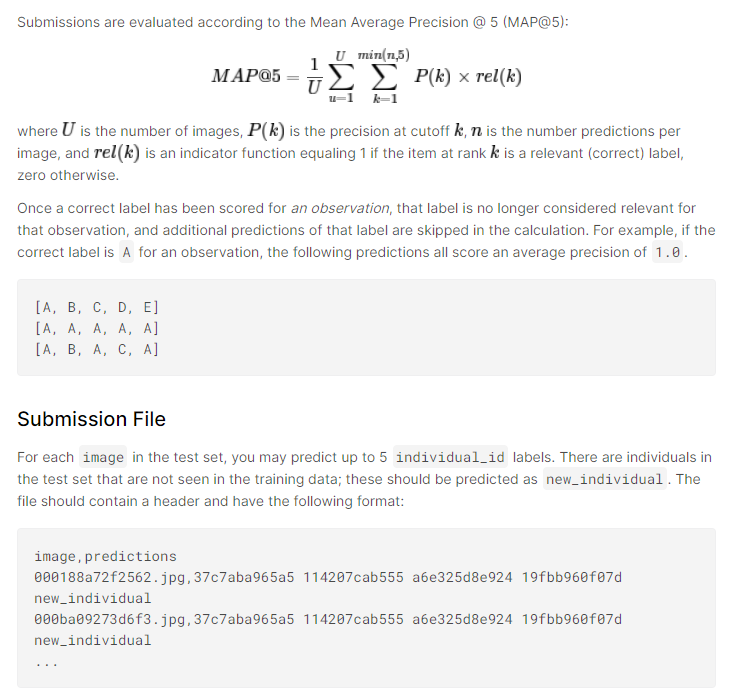

## Import packages

In [ ]:
# Install packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils 
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import cv2

## Load data

In [ ]:
train_data = pd.read_csv('../input/happy-whale-and-dolphin/train.csv')
sample_submission_data = pd.read_csv('../input/happy-whale-and-dolphin/sample_submission.csv')

## EDA

In [ ]:
print(train_data.shape, train_data['image'].nunique())
train_data.head()

In [ ]:
print(sample_submission_data.shape, sample_submission_data['image'].nunique())
display(sample_submission_data['predictions'].iloc[0])
sample_submission_data.head()

### Overlap of IDs - train and test datasets

In [ ]:
set_numbers_train = set(train_data['image'].tolist())
set_numbers_test = set(sample_submission_data['image'].tolist())
venn2((set_numbers_train, set_numbers_test), set_labels = ('Train IDs', 'Test IDs'))

## Sample images

In [ ]:
train_data['species'] = np.where(train_data['species'].isin(['beluga','globis']), train_data['species'] + '_whale', train_data['species'])
train_data['Dolphin or Whale'] = train_data['species'].apply(lambda x: 'Dolphin' if x.split('_')[-1]=='dolphin' else 'Whale')

temp = train_data['species'].value_counts().reset_index()
temp['index'] = np.where(temp['index'].isin(['beluga','globis']), temp['index'] + '_whale', temp['index'])
temp['Dolphin or Whale'] = temp['index'].apply(lambda x: 'Dolphin' if x.split('_')[-1]=='dolphin' else 'Whale')
temp.groupby(['Dolphin or Whale']).agg({'index':'nunique'}).reset_index().rename(columns = {'index':'# Distinct species'})

In [ ]:
print('\nSample dolphin images\n')
image_ids = train_data[train_data['Dolphin or Whale']=='Dolphin'].groupby("species").sample(n=1, random_state=1)
    
rows = 2
cols = 5
axes=[]
fig=plt.figure(figsize=(50, 25))

count = 0
for a in range(rows*cols):
    img_path = '../input/happy-whale-and-dolphin/train_images//' + train_data[train_data['image']==(image_ids['image'].iloc[count])]['image'].iloc[0]
    axes.append(fig.add_subplot(rows, cols, a+1))
    axes[-1].set_title(image_ids['species'].iloc[count], fontsize=30)
    plt.imshow(plt.imread(img_path))
    count +=1
    
fig.tight_layout()    
plt.show()

In [ ]:
print('\nSample whale images\n')
image_ids = train_data[train_data['Dolphin or Whale']=='Whale'].groupby("species").sample(n=1, random_state=1)
    
rows = 4
cols = 5
axes=[]
fig=plt.figure(figsize=(50, 25))

count = 0
for a in range(rows*cols):
    img_path = '../input/happy-whale-and-dolphin/train_images//' + train_data[train_data['image']==(image_ids['image'].iloc[count])]['image'].iloc[0]
    axes.append(fig.add_subplot(rows, cols, a+1))
    axes[-1].set_title(image_ids['species'].iloc[count], fontsize=30)
    plt.imshow(plt.imread(img_path))
    count +=1
    
fig.tight_layout()    
plt.show()

## Modelling

In [ ]:
Config = {'train_number_epochs': 100,
         'batch_size': 8}

In [ ]:
class SiameseNetwork(torch.nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(nn.Conv2d(1, 64, 3),
                                  nn.Conv2d(64, 64, 3),
                                  nn.Conv2d(64, 128, 3),
                                  nn.Conv2d(128, 128, 3),
                                  nn.Conv2d(128, 256, 3),
                                  nn.Conv2d(256, 256, 3),
                                  nn.MaxPool2d(2, 2),
                                  nn.Flatten(),
                                  nn.Linear(3748096, 4096)).cuda()

    def forward_once(self, x):
        output = self.cnn1(x.float())
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
img_shape = (256, 256)  # The image shape used by the model
class SiameseNetworkDataset():    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.images_path = f'../input/happy-whale-and-dolphin/{imageFolderDataset}_images'
        self.imageFolderDataset = os.listdir(self.images_path)    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset[index]
        img1_tuple = np.random.choice(self.imageFolderDataset)

        img0 = plt.imread(self.images_path + '//' + img0_tuple)
        img1 = plt.imread(self.images_path + '//' + img1_tuple)
        
        if len(img0.shape)==3:
            img0 = (cv2.resize(img0, img_shape) / 255)
        else:
            img0 = cv2.merge((img0, img0, img0))
            img0 = (cv2.resize(img0, img_shape) / 255)
            
        if len(img1.shape)==3:
            img1 = (cv2.resize(img1, img_shape) / 255)
        else:
            img1 = cv2.merge((img1, img1, img1))
            img1 = (cv2.resize(img1, img_shape) / 255)
            
        img0 = np.rollaxis(img0, 2, 0)[0:1,:,:]   
        img1 = np.rollaxis(img1, 2, 0)[0:1,:,:]
            
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return torch.tensor(img0), torch.tensor(img1), torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset)

In [ ]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset='train',
                                        transform=None,
                                        should_invert=False)

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config['batch_size'])

In [ ]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,Config['train_number_epochs']):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0][0]))